<a href="https://colab.research.google.com/github/FranklinCncr/TopicosEnComputacionGraficaGrupo/blob/master/4%20Operaciones%20globales%20en%20GPU/Ecualizacion%20de%20una%20imagen/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/topicos en grafica/laboratorio 4'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Laboratorio 4 Operaciones globales, ecualización

(425, 640)


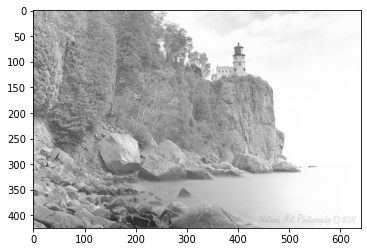

In [62]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread(path+'/img.jpg',0)

histograma = cv2.calcHist([img], [0], None, [256], [0,256])

funcion = np.zeros((256,1),dtype='int')
acumulado = 0
funcion[0] = 0
for i in range(1,255):
  funcion[i] = acumulado * 255/(img.shape[0]*img.shape[1])
  acumulado += histograma[i]
funcion[255] = 255

'''
#probando si funciona
img2 = cv2.imread(path+'/img.jpg',0)
for i in range (img2.shape[0]):
  for j in range (img2.shape[1]):
    img2[i][j] = funcion[img2[i][j]]

plt.imshow(img2, cmap='gray', vmin=0, vmax=255)
'''

arch = open(path+'/img.txt','w')
for i in img:
  for j in i:
    arch.write('%d\n' % j)
arch.close()

arch = open(path+'/funcion.txt','w')
for i in funcion:
  arch.write('%d\n' % i)
arch.close()

print(img.shape)

plt.imshow(img, cmap='gray', vmin=0, vmax=255)

In [0]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

In [59]:
%%cu
#include <bits/stdc++.h>

using namespace std;

__global__ void ecualizacion(int *dev_img, int *dev_funcion){
    
    int x = threadIdx.x + blockIdx.x*blockDim.x;
  
    dev_img[x] = dev_funcion[dev_img[x]];

}

int main(){
    
    int w = 640;
    int h = 425;

    int img[h*w];

    // matriz de imagen y arreglo de funcion de ecualizacion

    ifstream archImg("/content/drive/My Drive/topicos en grafica/laboratorio 4/img.txt");
    if (!archImg.is_open()) cout<<"No se abrió el archivo\n";
  
    for(int i=0; i<h; i++)
        for(int j=0; j<w; j++)
            archImg >> img[i*w+j];
    archImg.close();

    ifstream archFuncion("/content/drive/My Drive/topicos en grafica/laboratorio 4/funcion.txt");
    if (!archFuncion.is_open()) cout<<"No se abrió el archivo\n";
  
    int funcion[256];
    for(int i=0; i<256; i++)
            archFuncion >> funcion[i];
    archFuncion.close();

    // proceso

    int *dev_img, *dev_funcion;

    cudaMalloc((void **) &dev_img, sizeof(int)*w*h);
    cudaMalloc((void **) &dev_funcion, sizeof(int)*256);

    cudaMemcpy(dev_img, img, sizeof(int)*w*h, cudaMemcpyHostToDevice);
    cudaMemcpy(dev_funcion, funcion, sizeof(int)*256, cudaMemcpyHostToDevice);

    ecualizacion<<<h,w>>>(dev_img, dev_funcion);

    cudaMemcpy(img, dev_img, sizeof(int)*w*h, cudaMemcpyDeviceToHost);

    ofstream arch("/content/drive/My Drive/topicos en grafica/laboratorio 4/imgEcualizada.txt");

    for(int i=0; i<h; i++){
      for (int j=0; j<w; j++)
          arch<<img[i*w+j]<<"\n";
    }

    arch.close();

    cudaFree(dev_img);
    cudaFree(dev_funcion);

    cout<<"ok."<<'\n';

    return 0;
}

ok.



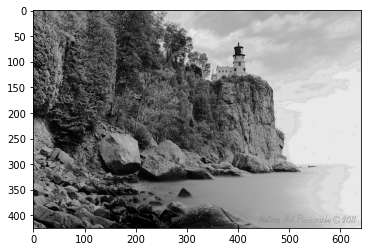

In [64]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

h = 425
w = 640

arch = open(path+'/imgEcualizada.txt','r')

imgEcualizada = np.zeros(( h, w), dtype=int)

for i in range (h):
  for j in range(w):
    k = arch.readline()
    imgEcualizada[i][j] = int(k)

cv2.imwrite(path+'/imgEcualizada.jpg', imgEcualizada)

plt.imshow(imgEcualizada, cmap='gray', vmin=0, vmax=255)

arch.close()
